# ```deepchem```: Machine Learning models for Drug Discovery
#Tutorial 1

Written by Evan Feinberg and Bharath Ramsundar

Copyright 2016, Stanford University

#Welcome to the ```deepchem``` tutorial. In this iPython Notebook, one can follow along with the code below to learn how to fit machine learning models with rich predictive power on chemical datasets.  

Overview:

In this tutorial, you will trace an arc from loading a raw dataset to fitting a cutting edge ML technique for predicting binding affinities. This will be accomplished by writing simple commands to access the deepchem Python API, encompassing the following broad steps:

1. Loading a chemical dataset, consisting of a series of protein-ligand complexes.
2. Featurizing each protein-ligand complexes with various featurization schemes. 
3. Fitting a series of models with these featurized protein-ligand complexes.
4. Visualizing the results.

First, let's point to a "dataset" file. This can come in the format of a CSV file or Pandas DataFrame. Regardless
of file format, it must be columnar data, where each row is a molecular system, and each column represents
a different piece of information about that system. For instance, in this example, every row reflects a 
protein-ligand complex, and the following columns are present: a unique complex identifier; the SMILES string
of the ligand; the binding affinity (Ki) of the ligand to the protein in the complex; a Python `list` of all lines
in a PDB file for the protein alone; and a Python `list` of all lines in a ligand file for the ligand alone.

This should become clearer with the example.


In [1]:
dataset_file= "../datasets/pdbbind_core_df.pkl.gz"
from deepchem.utils.save import load_from_disk
dataset = load_from_disk(dataset_file)

Let's see what `dataset` looks like:

In [2]:
print("Type of dataset is: %s" % str(type(dataset)))
print(dataset[:5])
print("Shape of dataset is: %s" % str(dataset.shape))

Type of dataset is: <class 'pandas.core.frame.DataFrame'>
  pdb_id                                             smiles  \
0   2d3u        CC1CCCCC1S(O)(O)NC1CC(C2CCC(CN)CC2)SC1C(O)O   
1   3cyx  CC(C)(C)NC(O)C1CC2CCCCC2C[NH+]1CC(O)C(CC1CCCCC...   
2   3uo4        OC(O)C1CCC(NC2NCCC(NC3CCCCC3C3CCCCC3)N2)CC1   
3   1p1q                         CC1ONC(O)C1CC([NH3+])C(O)O   
4   3ag9  NC(O)C(CCC[NH2+]C([NH3+])[NH3+])NC(O)C(CCC[NH2...   

                                          complex_id  \
0    2d3uCC1CCCCC1S(O)(O)NC1CC(C2CCC(CN)CC2)SC1C(O)O   
1  3cyxCC(C)(C)NC(O)C1CC2CCCCC2C[NH+]1CC(O)C(CC1C...   
2    3uo4OC(O)C1CCC(NC2NCCC(NC3CCCCC3C3CCCCC3)N2)CC1   
3                     1p1qCC1ONC(O)C1CC([NH3+])C(O)O   
4  3ag9NC(O)C(CCC[NH2+]C([NH3+])[NH3+])NC(O)C(CCC...   

                                         protein_pdb  \
0  [HEADER    2D3U PROTEIN\n, COMPND    2D3U PROT...   
1  [HEADER    3CYX PROTEIN\n, COMPND    3CYX PROT...   
2  [HEADER    3UO4 PROTEIN\n, COMPND    3UO4 PROT...   
3 

One of the missions of ```deepchem``` is to form a synapse between the chemical and the algorithmic worlds: to be able to leverage the powerful and diverse array of tools available in Python to analyze molecules. This ethos applies to visual as much as quantitative examination:

In [3]:
import nglview
import tempfile
import os
import mdtraj as md
import numpy as np
import deepchem.utils.visualization
reload(deepchem.utils.visualization)
from deepchem.utils.visualization import combine_mdtraj, visualize_complex, convert_lines_to_mdtraj

first_protein, first_ligand = dataset.iloc[0]["protein_pdb"], dataset.iloc[0]["ligand_pdb"]

protein_mdtraj = convert_lines_to_mdtraj(first_protein)
ligand_mdtraj = convert_lines_to_mdtraj(first_ligand)
complex_mdtraj = combine_mdtraj(protein_mdtraj, ligand_mdtraj)

In [4]:
def visualize_complex(complex_mdtraj):
  ligand_atoms = [a.index for a in complex_mdtraj.topology.atoms if "LIG" in str(a.residue)]
  binding_pocket_atoms = md.compute_neighbors(complex_mdtraj, 0.5, ligand_atoms)[0]
  binding_pocket_residues = list(set([complex_mdtraj.topology.atom(a).residue.resSeq for a in binding_pocket_atoms]))
  binding_pocket_residues = [str(r) for r in binding_pocket_residues]
  binding_pocket_residues = " or ".join(binding_pocket_residues)

  traj = nglview.MDTrajTrajectory( complex_mdtraj ) # load file from RCSB PDB
  ngltraj = nglview.NGLWidget( traj )
  ngltraj.representations = [
  { "type": "cartoon", "params": {
  "sele": "protein", "color": "residueindex"
  } },
  { "type": "licorice", "params": {
  "sele": "(not hydrogen) and (resi (%s))" %  binding_pocket_residues
  } },
  { "type": "ball+stick", "params": {
  "sele": "resn LIG"
  } }
  ]
  return ngltraj

In [5]:
ngltraj = visualize_complex(complex_mdtraj)
ngltraj

/home/enf/anaconda/lib/python2.7/site-packages/ipywidgets/widgets/widget.py:157: DeprecationWarning: Widget._keys_default is deprecated: use @default decorator instead.
  def _keys_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/ipywidgets/widgets/widget.py:157: DeprecationWarning: Widget._keys_default is deprecated: use @default decorator instead.
  def _keys_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/home/enf/anaconda/li

Now that we're oriented, let's use ML to do some chemistry. 

So, step (2) will entail featurizing the dataset.

The available featurizations that come standard with deepchem are ECFP4 fingerprints, RDKit descriptors, NNScore-style bdescriptors, and hybrid binding pocket descriptors. Details can be found on ```deepchem.io```.

In [6]:
from deepchem.featurizers.fingerprints import CircularFingerprint
from deepchem.featurizers.basic import RDKitDescriptors
from deepchem.featurizers.nnscore import NNScoreComplexFeaturizer
from deepchem.featurizers.grid_featurizer import GridFeaturizer
grid_featurizer = GridFeaturizer(voxel_width=16.0, feature_types="voxel_combined", voxel_feature_types=["ecfp",
                                 "splif", "hbond", "pi_stack", "cation_pi", "salt_bridge"], ecfp_power=5, splif_power=5,
                                 parallel=True, flatten=True)
compound_featurizers = [CircularFingerprint(size=128)]
complex_featurizers = [grid_featurizer]

Note how we separate our featurizers into those that featurize individual chemical compounds, compound_featurizers, and those that featurize molecular complexes, complex_featurizers.

Now, let's perform the actual featurization. Calling ```featurizer.featurize()``` will return an instance of class ```FeaturizedSamples```. Internally, ```featurizer.featurize()``` (a) computes the user-specified features on the data, (b) transforms the inputs into X and y NumPy arrays suitable for ML algorithms, and (c) constructs a ```FeaturizedSamples()``` instance that has useful methods, such as an iterator, over the featurized data.

In [7]:
#Make a directory in which to store the featurized complexes.
import tempfile, shutil
feature_dir = tempfile.mkdtemp()
samples_dir = tempfile.mkdtemp()

In [16]:
import deepchem.featurizers.featurize
reload(deepchem.featurizers.featurize)
from deepchem.featurizers.featurize import DataFeaturizer

import warnings
warnings.filterwarnings("ignore")

deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  d

In [9]:

featurizers = compound_featurizers + complex_featurizers
featurizer = DataFeaturizer(tasks=["label"],
                            smiles_field="smiles",
                            protein_pdb_field="protein_pdb",
                            ligand_pdb_field="ligand_pdb",
                            compound_featurizers=compound_featurizers,
                            complex_featurizers=complex_featurizers,
                            id_field="complex_id",
                            verbose=False)
featurized_samples = featurizer.featurize(dataset_file, feature_dir, samples_dir,
                                          shard_size=32)

deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  d

In [13]:
from deepchem.utils.save import save_to_disk, load_from_disk
featurized_samples_file = "examples/tutorial_samples.joblib"
save_to_disk(featurized_samples, featurized_samples_file)

deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  d

In [14]:
featurized_samples = load_from_disk(featurized_samples_file)

deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  d

Now, we conduct a train-test split. If you'd like, you can choose `splittype="scaffold"` instead to perform a train-test split based on Bemis-Murcko scaffolds.

In [18]:
splittype = "random"
train_dir, test_dir = tempfile.mkdtemp(), tempfile.mkdtemp()

train_samples, test_samples = featurized_samples.train_test_split(
    splittype, train_dir, test_dir, seed=2016)

deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  d

SyntaxError: invalid syntax (<ipython-input-18-2f47ea2b31f3>, line 1)

deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  d

We generate separate instances of the Dataset() object to hermetically seal the train dataset from the test dataset. This style lends itself easily to validation-set type hyperparameter searches, which we will illustate in a separate section of this tutorial. 

In [19]:
from deepchem.utils.dataset import Dataset

deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  d

In [20]:
train_dataset = Dataset(data_dir=train_dir, samples=train_samples, 
                        featurizers=compound_featurizers, tasks=["label"])
test_dataset = Dataset(data_dir=test_dir, samples=test_samples, 
                       featurizers=compound_featurizers, tasks=["label"])

deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  d

The performance of many ML algorithms hinges greatly on careful data preprocessing. Deepchem comes standard with a few options for such preprocessing.

In [21]:
input_transforms = ["normalize", "truncate"]
output_transforms = ["normalize"]
train_dataset.transform(input_transforms, output_transforms)
test_dataset.transform(input_transforms, output_transforms)

deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  d

Now, we're ready to do some learning! To set up a model, we will need: (a) a dictionary ```task_types``` that maps a task, in this case ```label```, i.e. the Ki, to the type of the task, in this case ```regression```. For the multitask use case, one will have a series of keys, each of which is a different task (Ki, solubility, renal half-life, etc.) that maps to a different task type (regression or classification).

To fit a deepchem model, first we instantiate one of the provided (or user-written) model classes. In this case, we have a created a convenience class to wrap around any ML model available in Sci-Kit Learn that can in turn be used to interoperate with deepchem. To instantiate an ```SklearnModel```, you will need (a) task_types, (b) model_params, another ```dict``` as illustrated below, and (c) a ```model_instance``` defining the type of model you would like to fit, in this case a ```RandomForestRegressor```.

In [22]:
from sklearn.ensemble import RandomForestRegressor
from deepchem.models.standard import SklearnModel

deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  d

In [23]:
task_types = {"label": "regression"}
model_params = {"data_shape": train_dataset.get_data_shape()}

model = SklearnModel(task_types, model_params, model_instance=RandomForestRegressor())
model.fit(train_dataset)
model_dir = tempfile.mkdtemp()
model.save(model_dir)

deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dtype=np.int8)
deepchem/featurizers/grid_featurizer.py:987: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  d

In [24]:
from deepchem.utils.evaluate import Evaluator
import pandas as pd

In [47]:
evaluator = Evaluator(model, train_dataset, verbose=True)
with tempfile.NamedTemporaryFile() as train_csv_out:
  with tempfile.NamedTemporaryFile() as train_stats_out:
    _, train_r2score = evaluator.compute_model_performance(
        train_csv_out, train_stats_out)

evaluator = Evaluator(model, test_dataset, verbose=True)
test_csv_out = tempfile.NamedTemporaryFile()
with tempfile.NamedTemporaryFile() as test_stats_out:
    _, test_r2score = evaluator.compute_model_performance(
        test_csv_out, test_stats_out)

print test_csv_out.name
train_test_performance = pd.concat([train_r2score, test_r2score])
train_test_performance["split"] = ["train", "test"]
train_test_performance

Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fd04afe6030>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7fd04afe6db0>
Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fd04afe6e40>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7fd04afe6c00>
/local-scratch/enf/12500/tmp4C1Epq


,task_name,r2_score,rms_error,split
0,label,0.830519,0.953774,train
0,label,0.153050,1.778543,test


In this simple example, in few yet intuitive lines of code, we traced the machine learning arc from featurizing a raw dataset to fitting and evaluating a model. 

Here, we featurized only the ligand. The signal we observed in R^2 reflects the ability of circular fingerprints and random forests to learn general features that make ligands "drug-like."

Let's take a quick look at what the algorithm determines to be high- and low-affinity drugs.



In [49]:
predictions = pd.read_csv(test_csv_out.name)
print(predictions)
predictions = predictions.sort(['label'], ascending=[0])

    Unnamed: 0                                                ids     label  \
0            2    3uo4OC(O)C1CCC(NC2NCCC(NC3CCCCC3C3CCCCC3)N2)CC1  0.127371   
1            7  4tmnCC(C)CC(N[PH](O)(O)C(CC1CCCCC1)NC(O)OCC1CC...  2.016046   
2           26                   2g70OCC1CC2CCC(N(O)O)CC2C[NH2+]1  0.774178   
3           28                                 3u9qCCCCCCCCCC(O)O -0.979962   
4           32               2pcpC1CCC(C2([NH+]3CCCCC3)CCCCC2)CC1  1.255402   
5           36  3bpcCCCOC1(C(O)O)CC(O)C(O)C(C(O)COC2(C([O-])O)... -0.762635   
6           37  2vw5COC1CC(C)CC2CC(O)CC(C2)NC(O)C(C)CCCC(C)C(O...  1.162261   
7           46                          1o5bNC(N)C1CC2C(CCCC2I)S1 -0.260713   
8           48  10gs[NH3+]C(CCC(O)NC(CSCC1CCCCC1)C(O)NC(C([O-]...  0.065278   
9           55                    1hnnNS(O)(O)C1CCC2CC[NH2+]CC2C1 -0.017514   
10          74                       3fk1OC(O)C[NH2+]C[PH](O)(O)O -1.890665   
11          76                               3gy4NC(

In [58]:
top_ligand = predictions.iloc[0]['ids']
ligand1 = convert_lines_to_mdtraj(dataset.loc[dataset['complex_id']==top_ligand]['ligand_pdb'].values[0])

def visualize_ligand(ligand_mdtraj):
  traj = nglview.MDTrajTrajectory( ligand_mdtraj ) # load file from RCSB PDB
  ngltraj = nglview.NGLWidget( traj )
  ngltraj.representations = [
  { "type": "ball+stick", "params": {
  "sele": "all"
  } }
  ]
  return ngltraj

ngltraj = visualize_ligand(ligand1)
ngltraj

In [65]:
top_ligand = predictions.iloc[1]['ids']
ligand1 = convert_lines_to_mdtraj(dataset.loc[dataset['complex_id']==top_ligand]['ligand_pdb'].values[0])
ngltraj = visualize_ligand(ligand1)
ngltraj

In [66]:
worst_ligand = predictions.iloc[predictions.shape[0]-2]['ids']
ligand1 = convert_lines_to_mdtraj(dataset.loc[dataset['complex_id']==worst_ligand]['ligand_pdb'].values[0])
ngltraj = visualize_ligand(ligand1)
ngltraj

In [67]:
worst_ligand = predictions.iloc[predictions.shape[0]-3]['ids']
ligand1 = convert_lines_to_mdtraj(dataset.loc[dataset['complex_id']==worst_ligand]['ligand_pdb'].values[0])
ngltraj = visualize_ligand(ligand1)
ngltraj

# The protein-ligand complex view.

The preceding simple example, in few yet intuitive lines of code, traces the machine learning arc from featurizing a raw dataset to fitting and evaluating a model. 

In this next section, we illustrate ```deepchem```'s modularity, and thereby the ease with which one can explore different featurization schemes, different models, and combinations thereof, to achieve the best performance on a given dataset. We will demonstrate this by examining protein-ligand interactions. 

In the previous section, we featurized only the ligand. The signal we observed in R^2 reflects the ability of circular fingerprints and random forests to learn general features that make ligands "drug-like." However, the affinity of a drug for a target is determined not only by the drug itself, of course, but the way in which it interacts with a protein. 

In [109]:
train_dir, validation_dir, test_dir = tempfile.mkdtemp(), tempfile.mkdtemp(), tempfile.mkdtemp()
splittype="random"
train_samples, validation_samples, test_samples = featurized_samples.train_valid_test_split(
    splittype, train_dir, validation_dir, test_dir, seed=2016)

task_types = {"label": "regression"}
performance = pd.DataFrame()
import deepchem.models.standard
from deepchem.models.standard import SklearnModel
from deepchem.utils.dataset import Dataset
from deepchem.utils.evaluate import Evaluator

n_trees_vals = [10, 20, 40, 80, 160, 320, 640, 1280]
for feature_type in (complex_featurizers + compound_featurizers):
    train_dataset = Dataset(data_dir=train_dir, samples=train_samples, 
                        featurizers=[feature_type], tasks=["label"])
    validation_dataset = Dataset(data_dir=validation_dir, samples=validation_samples, 
                       featurizers=[feature_type], tasks=["label"])

    input_transforms = ["normalize", "truncate"]
    output_transforms = ["normalize"]
    train_dataset.transform(input_transforms, output_transforms)
    validation_dataset.transform(input_transforms, output_transforms)
    
    for n_trees in n_trees_vals:
        model_params = {"data_shape": train_dataset.get_data_shape()}

        model = SklearnModel(task_types, model_params, model_instance=RandomForestRegressor(n_estimators=n_trees))
        model.fit(train_dataset)
        model_dir = tempfile.mkdtemp()
        model.save(model_dir)


        evaluator = Evaluator(model, train_dataset, verbose=True)
        with tempfile.NamedTemporaryFile() as train_csv_out:
          with tempfile.NamedTemporaryFile() as train_stats_out:
            _, train_r2score = evaluator.compute_model_performance(
                train_csv_out, train_stats_out)

        evaluator = Evaluator(model, validation_dataset, verbose=True)
        with tempfile.NamedTemporaryFile() as validation_csv_out:
          with tempfile.NamedTemporaryFile() as validation_stats_out:
            _, validation_r2score = evaluator.compute_model_performance(
                validation_csv_out, validation_stats_out)

        train_valid_performance = pd.concat([train_r2score, validation_r2score])
        train_valid_performance["split"] = ["train", "validation"]
        train_valid_performance["featurizer"] = [str(feature_type.__class__), str(feature_type.__class__)]
        train_valid_performance["n_trees"] = [n_trees, n_trees]
        print(train_valid_performance)
        performance = pd.concat([performance, train_valid_performance])
performance

Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fd0510b4d20>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7fd04afe6ed0>
Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fd04afe61e0>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7fd04afe6e40>
  task_name  r2_score  rms_error       split  \
0     label  0.850802   0.890800       train   
0     label  0.380784   1.172148  validation   

                                          featurizer  n_trees  
0  <class 'deepchem.featurizers.grid_featurizer.G...       10  
0  <class 'deepchem.featurizers.grid_featurizer.G...       10  
Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fd04afe6c00>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7fd0510b4d20>
Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fd04afe6ed0>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7fd04afe61e0>
  task_name

,task_name,r2_score,rms_error,split,featurizer,n_trees
0,label,0.850802,0.890800,train,<class 'deepchem.featurizers.grid_featurizer.G...,10
0,label,0.380784,1.172148,validation,<class 'deepchem.featurizers.grid_featurizer.G...,10
0,label,0.877179,0.808230,train,<class 'deepchem.featurizers.grid_featurizer.G...,20
0,label,0.157616,1.367150,validation,<class 'deepchem.featurizers.grid_featurizer.G...,20
0,label,0.900207,0.728532,train,<class 'deepchem.featurizers.grid_featurizer.G...,40
0,label,0.279117,1.264717,validation,<class 'deepchem.featurizers.grid_featurizer.G...,40
0,label,0.895135,0.746817,train,<class 'deepchem.featurizers.grid_featurizer.G...,80
0,label,0.303473,1.243169,validation,<class 'deepchem.featurizers.grid_featurizer.G...,80
0,label,0.904690,0.711980,train,<class 'deepchem.featurizers.grid_featurizer.G...,160
0,label,0.275001,1.268323,validation,<class 'deepchem.featurizers.grid_featurizer.G...,160


     rms_error
10     1.37714
20     1.21434
40     1.24974
80     1.24305
160    1.31865
320    1.29587
640      1.264
1280   1.28438
     fingerprints    grids
10        1.37714  1.17215
20        1.21434  1.36715
40        1.24974  1.26472
80        1.24305  1.24317
160       1.31865  1.26832
320       1.29587  1.27902
640         1.264  1.27159
1280      1.28438  1.26187


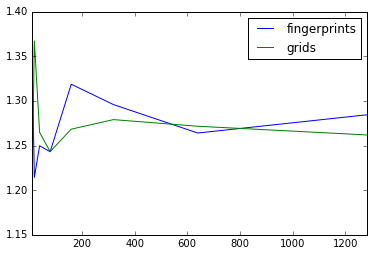

In [121]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(performance[['rms_error','split','featurizer']].values, index=performance['n_trees'].values, columns=['rms_error', 'split', 'featurizer'])
df = df.loc[df['split']=="validation"]
df = df.drop('split', 1)
fingerprint_df = df[df['featurizer'].str.contains('fingerprint')].drop('featurizer', 1)
print fingerprint_df
fingerprint_df.columns = ['fingerprints']
grid_df = df[df['featurizer'].str.contains('grid')].drop('featurizer', 1)
grid_df.columns = ['grids']
df = pd.concat([fingerprint_df, grid_df], axis=1)
print(df)

plt.clf()
df.plot()

In [151]:
train_dir, validation_dir, test_dir = tempfile.mkdtemp(), tempfile.mkdtemp(), tempfile.mkdtemp()
splittype="random"
train_samples, validation_samples, test_samples = featurized_samples.train_valid_test_split(
    splittype, train_dir, validation_dir, test_dir, seed=2016)

feature_type = complex_featurizers
train_dataset = Dataset(data_dir=train_dir, samples=train_samples, 
                    featurizers=feature_type, tasks=["label"])
validation_dataset = Dataset(data_dir=validation_dir, samples=validation_samples, 
                   featurizers=feature_type, tasks=["label"])
test_dataset = Dataset(data_dir=test_dir, samples=test_samples, 
                   featurizers=feature_type, tasks=["label"])

input_transforms = ["normalize", "truncate"]
output_transforms = ["normalize"]
train_dataset.transform(input_transforms, output_transforms)
validation_dataset.transform(input_transforms, output_transforms)
test_dataset.transform(input_transforms, output_transforms)

model_params = {"data_shape": train_dataset.get_data_shape()}

model = SklearnModel(task_types, model_params, model_instance=RandomForestRegressor(n_estimators=1200))
model.fit(train_dataset)
model_dir = tempfile.mkdtemp()
model.save(model_dir)


evaluator = Evaluator(model, train_dataset, verbose=True)
with tempfile.NamedTemporaryFile() as train_csv_out:
  with tempfile.NamedTemporaryFile() as train_stats_out:
    _, train_r2score = evaluator.compute_model_performance(
        train_csv_out, train_stats_out)

evaluator = Evaluator(model, test_dataset, verbose=True)
test_csv_out = tempfile.NamedTemporaryFile()
with tempfile.NamedTemporaryFile() as test_stats_out:
    predictions, test_r2score = evaluator.compute_model_performance(
        test_csv_out, test_stats_out)

train_test_performance = pd.concat([train_r2score, test_r2score])
train_test_performance["split"] = ["train", "test"]
train_test_performance["featurizer"] = [str(feature_type.__class__), str(feature_type.__class__)]
train_test_performance["n_trees"] = [n_trees, n_trees]
print(train_test_performance)

Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fd03db00f60>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7fd0486bbb70>
Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fd03eae6c90>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7fd04afe6ed0>
  task_name  r2_score  rms_error  split     featurizer  n_trees
0     label  0.907324   0.702072  train  <type 'list'>     1280
0     label  0.448132   1.250414   test  <type 'list'>     1280


                                                   ids      label label_pred
155  3gnwCC1CCCC(C(O)N2C3CCCC(O)C3NC3CC(C)(C)CS(O)(...    1.31713   0.617186
107  2p4yCOC1CCC2C(C1)ONC2C1C(C)N(CC2CC(OC(C)C([O-]...    1.25772   0.751776
172  1hfsCC(C)CC(NC(O)C(CCC1CCC(C2CCC(F)CC2)CC1)CC(...    1.07949   0.724343
171  3ge7CNC1NC2CC3C(O)[NH2+][CH2+](N)NC3C(CC[NH2+]...    1.07949   0.586262
162  1h23OC1CCC2C(CCCC2[NH2+]CCCCCCCCCCCC[NH2+]C2CC...   0.871553   0.606028
190  2pq9[O-]C(O)C1CC(OC(O[PH](O)(O)O)(C([O-])O)C(F...   0.728968   0.393901
137                   4g8m[NH3+]C(C(O)O)C1CCC1C([O-])O   0.598264  -0.479275
146                   3kv2N[CH2+](NO)NCCC([NH3+])C(O)O   0.259624  -0.715818
34                 2vvnCCN[CH2+]1NC2C(OC(CO)C(O)C2O)S1   0.247742  -0.248969
180  2ole[NH3+]C(CC(O)N1CCCCCN1C(O)C1CCCCC1)CC1CC(F...   0.218037 -0.0644886
141  1z95CC(O)(CS(O)(O)C1CCC(F)CC1)C(O)NC1CCC(CN)C(...   0.140803   0.325723
29          3gbb[NH3+]C(CC1(C([O-])O)CC2OCCCC2O1)C(O)O  0.0100998 -0.0727886

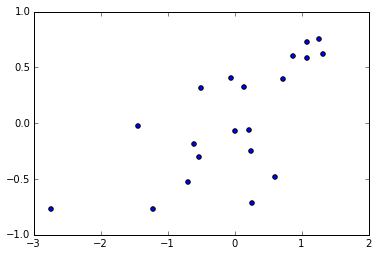

In [152]:
predictions = predictions.sort(['label'], ascending=[0])
print(predictions[["ids", "label", "label_pred"]])
plt.clf()
plt.figure()
plt.scatter(predictions["label"], predictions["label_pred"])

In [149]:
top_complex = predictions.iloc[0]['ids']
best_complex = dataset.loc[dataset['complex_id']==top_complex]

protein_mdtraj = convert_lines_to_mdtraj(best_complex["protein_pdb"].values[0])
ligand_mdtraj = convert_lines_to_mdtraj(best_complex["ligand_pdb"].values[0])
complex_mdtraj = combine_mdtraj(protein_mdtraj, ligand_mdtraj)
ngltraj = visualize_complex(complex_mdtraj)
ngltraj

In [141]:
top_complex = predictions.iloc[1]['ids']
best_complex = dataset.loc[dataset['complex_id']==top_complex]

protein_mdtraj = convert_lines_to_mdtraj(best_complex["protein_pdb"].values[0])
ligand_mdtraj = convert_lines_to_mdtraj(best_complex["ligand_pdb"].values[0])
complex_mdtraj = combine_mdtraj(protein_mdtraj, ligand_mdtraj)
ngltraj = visualize_complex(complex_mdtraj)
ngltraj

In [143]:
top_complex = predictions.iloc[predictions.shape[0]-1]['ids']
best_complex = dataset.loc[dataset['complex_id']==top_complex]

protein_mdtraj = convert_lines_to_mdtraj(best_complex["protein_pdb"].values[0])
ligand_mdtraj = convert_lines_to_mdtraj(best_complex["ligand_pdb"].values[0])
complex_mdtraj = combine_mdtraj(protein_mdtraj, ligand_mdtraj)
ngltraj = visualize_complex(complex_mdtraj)
ngltraj

In [ ]:
class fingerprints32(CircularFingerprint):
    def __init__(self):
        super(fingerprints32, self).__init__(size=32)
        
class fingerprints64(CircularFingerprint):
    def __init__(self):
        super(fingerprints64, self).__init__(size=64)
        
class fingerprints128(CircularFingerprint):
    def __init__(self):
        super(fingerprints128, self).__init__(size=128)

class fingerprints256(CircularFingerprint):
    def __init__(self):
        super(fingerprints256, self).__init__(size=256)

class fingerprints512(CircularFingerprint):
    def __init__(self):
        super(fingerprints512, self).__init__(size=512)
        

In [ ]:
from imp import reload
import deepchem.featurizers.grid_featurizer
reload(deepchem.featurizers.grid_featurizer)
from deepchem.featurizers.grid_featurizer import GridFeaturizer 
compound_featurizers = [fingerprints32(), fingerprints64(), fingerprints128(), fingerprints256(), fingerprints512()]
complex_featurizers = [GridFeaturizer(voxel_width=16.0, feature_types="voxel_combined", voxel_feature_types=["ecfp",
                                      "splif", "hbond", "pi_stack", "cation_pi", "salt_bridge"], ecfp_power=5, splif_power=5,
                                     parallel=True, flatten=True)]

featurizers = compound_featurizers + complex_featurizers
featurizer = DataFeaturizer(tasks=["label"],
                            smiles_field="smiles",
                            protein_pdb_field="protein_pdb",
                            ligand_pdb_field="ligand_pdb",
                            compound_featurizers=compound_featurizers,
                            complex_featurizers=complex_featurizers,
                            id_field="complex_id",
                            verbose=False)
featurized_samples = featurizer.featurize(dataset_file, feature_dir, samples_dir,
                                          shard_size=100)
print("Done featurizing.")
train_dir, test_dir = tempfile.mkdtemp(), tempfile.mkdtemp()
splittype="scaffold"
train_samples, test_samples = featurized_samples.train_test_split(
    splittype, train_dir, test_dir)

task_types = {"label": "regression"}


performance = pd.DataFrame()
all_featurizers = compound_featurizers + complex_featurizers


In [ ]:
dataset_file= "../datasets/pdbbind_core_df.pkl.gz"
from deepchem.utils.save import load_from_disk
from deepchem.featurizers.featurize import DataFeaturizer
dataset = load_from_disk(dataset_file)

from imp import reload
import deepchem.featurizers.grid_featurizer
reload(deepchem.featurizers.grid_featurizer)
from deepchem.featurizers.grid_featurizer import GridFeaturizer 
import deepchem.featurizers.featurize
reload(deepchem.featurizers.featurize)
from deepchem.featurizers.featurize import DataFeaturizer

compound_featurizers = []
complex_featurizers = [GridFeaturizer(voxel_width=16.0, feature_types="voxel_combined", voxel_feature_types=["ecfp",
                                      "splif", "hbond", "pi_stack", "cation_pi", "salt_bridge"], ecfp_power=5, splif_power=5,
                                     parallel=True, flatten=True)]

import tempfile
feature_dir = tempfile.mkdtemp()
samples_dir = tempfile.mkdtemp()

featurizers = compound_featurizers + complex_featurizers
featurizer = DataFeaturizer(tasks=["label"],
                            smiles_field="smiles",
                            protein_pdb_field="protein_pdb",
                            ligand_pdb_field="ligand_pdb",
                            compound_featurizers=compound_featurizers,
                            complex_featurizers=complex_featurizers,
                            id_field="complex_id",
                            verbose=False)
featurized_samples = featurizer.featurize(dataset_file, feature_dir, samples_dir,
                                          shard_size=100)

# Hyperparameter search:

In [ ]:
import pandas as pd
import deepchem.models.standard
from deepchem.models.deep import SingleTaskDNN
from deepchem.utils.dataset import Dataset
from deepchem.utils.evaluate import Evaluator

train_dir, validation_dir, test_dir = tempfile.mkdtemp(), tempfile.mkdtemp(), tempfile.mkdtemp()
splittype="random"
train_samples, validation_samples, test_samples = featurized_samples.train_valid_test_split(
    splittype, train_dir, validation_dir, test_dir)

task_types = {"label": "regression"}
performance = pd.DataFrame()


feature_type = complex_featurizers[0]

hyperparameter_df = pd.DataFrame()
train_dataset = Dataset(data_dir=train_dir, samples=train_samples, 
                    featurizers=[feature_type], tasks=["label"])
validation_dataset = Dataset(data_dir=validation_dir, samples=validation_samples, 
                    featurizers=[feature_type], tasks=["label"])
test_dataset = Dataset(data_dir=test_dir, samples=test_samples, 
                   featurizers=[feature_type], tasks=["label"])


input_transforms = ["normalize", "truncate"]
output_transforms = ["normalize"]
train_dataset.transform(input_transforms, output_transforms)
validation_dataset.transform(input_transforms, output_transforms)
test_dataset.transform(input_transforms, output_transforms)

model_params = {"data_shape": train_dataset.get_data_shape(),
                "batch_size": 128, "decay": 1e-4,
                "init": "glorot_uniform", 
                "momentum": .9, "nesterov": False,
                "nb_epoch": 25}

learning_rate_vals = [0.001]
nb_hidden_vals = [1, 2, 3, 10]
dropout_vals = [0.0, 0.1, 0.25]
activation_vals = ["relu"]

for learning_rate in learning_rate_vals:
    model_params["learning_rate"] = learning_rate
    for nb_hidden in nb_hidden_vals:
        model_params["nb_hidden"] = nb_hidden
        for dropout in dropout_vals:
            model_params["dropout"] = dropout
            for activation in activation_vals:
                model_params["activation"] = activation
                model = SingleTaskDNN(task_types, model_params)
                model.fit(train_dataset)
                evaluator = Evaluator(model, validation_dataset, verbose=True)
                with tempfile.NamedTemporaryFile() as validation_csv_out:
                  with tempfile.NamedTemporaryFile() as validation_stats_out:
                    _, validation_r2score = evaluator.compute_model_performance(
                        validation_csv_out, validation_stats_out)
                validation_r2score["learning_rate"] = learning_rate
                validation_r2score["nb_hidden"] = nb_hidden
                validation_r2score["dropout"] = dropout
                validation_r2score["activation"] = activation
                print(validation_r2score)
                hyperparameter_df = pd.concat([hyperparameter_df, validation_r2score])
print(hyperparameter_df)


In [ ]:
hyperparameter_df = hyperparameter_df.sort(['r2_score'], ascending=[0])
best_model = hyperparameter_df.iloc[0]
model_params["batch_size"] = 100
model_params["learning_rate"] = 0.001 #best_model["learning_rate"]
model_params["nb_hidden"] = best_model["nb_hidden"]
model_params["dropout"] = best_model["dropout"]
model_params["activation"] = best_model["activation"]
model_params["nb_epoch"] = 100
print(hyperparameter_df.iloc[0])
print(model_params)

model = SingleTaskDNN(task_types, model_params)
model.fit(train_dataset)
evaluator = Evaluator(model, test_dataset, verbose=True)
with tempfile.NamedTemporaryFile() as test_csv_out:
  with tempfile.NamedTemporaryFile() as test_stats_out:
    _, test_r2score = evaluator.compute_model_performance(
        test_csv_out, test_stats_out)

print(test_r2score)

In [ ]:
model = SklearnModel(task_types, model_params, model_instance=RandomForestRegressor(n_estimators=1000))
model.fit(train_dataset)
evaluator = Evaluator(model, test_dataset, verbose=True)
with tempfile.NamedTemporaryFile() as test_csv_out:
  with tempfile.NamedTemporaryFile() as test_stats_out:
    _, test_r2score = evaluator.compute_model_performance(
        test_csv_out, test_stats_out)

print(test_r2score)


While we have computed three separate featurizations -- ECFP4, RDKitDescriptors, and NNScore -- in this example we choose to use the RDKitDescriptors featurization. This will serve as a baseline as you apply more advanced featurization schemes.

It is essential for many ML methods, depending on the data type, to perform preprocessing in order to attain optimal performance. Here, we choose to normalize and truncate the inputs (X, the featurized complexes) while normalizing the output (y, the binding affinities):

To recap, the initial dataset has now been featurized, split into train and test sets, and transformed. We are now ready to learn some chemistry! To warm up, let's apply a more traditional but quite robust statistical learning technique: random forests.

Now that we've fit an Random Forest Regressor on the data, let's evaluate its performance:

Let's compare this to performance with a deep neural network.

In [ ]:
from deepchem.models import Model

task_type = "regression"
model_params = {"activation": "relu",
              "dropout": 0.,
              "momentum": .9, "nesterov": False,
              "decay": 1e-4, "batch_size": 5,
              "nb_epoch": 10}
model_name = "singletask_deep_regressor"

nb_hidden_vals = [10, 100]
learning_rate_vals = [.01, .001]
init_vals = ["glorot_uniform"]
hyperparameters = [nb_hidden_vals, learning_rate_vals, init_vals]
hyperparameter_rows = []
for hyperparameter_tuple in itertools.product(*hyperparameters):
    nb_hidden, learning_rate, init = hyperparameter_tuple
    model_params["nb_hidden"] = nb_hidden
    model_params["learning_rate"] = learning_rate
    model_params["init"] = init

    model_dir = tempfile.mkdtemp()

    r2_score = create_and_eval_model(train_dataset, test_dataset, task_type,
                                     model_params, model_name, model_dir, tasks)

    print("%s: %s" % (hyperparameter_tuple, r2_score))
    hyperparameter_rows.append(list(hyperparameter_tuple) + [r2_score])

    shutil.rmtree(model_dir)

hyperparameter_df = pd.DataFrame(hyperparameter_rows,
                               columns=('nb_hidden', 'learning_rate',
                                        'init', 'r2_score'))

hyperparameter_df